# Measurement-induced dephasing on Starmon-5

In [1]:
import qiskit.tools.jupyter
import qiskit.circuit.library.standard_gates as gates
import qiskit.tools.visualization as qvis

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, inspire_login, get_starmon_status
from inspire_experiments.analysis_tools import *
reload(inspire_experiments.analysis_tools)

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%qiskit_version_table

In [2]:
api, backend = inspire_login()
backend.status()

Backend status:  EXECUTION


In [3]:

get_starmon_status(api)

'EXECUTION'

## Readout error correction

In [4]:
def extract_readout_correction(qubit, filename: str="readout_correction"):
    # data_0 = get_json_data(filename.format(qubit) + "_state0" + "_PROB.json")
    # data_1 = get_json_data(filename.format(qubit) + "_state1" + "_PROB.json")
    # print([list(data_0[0].values())[0] - list(data_0[0].values())[1], list(data_1[0].values())[0] - list(data_1[0].values())[1]] )

    data_0 = ExperimentData.get_csv_data(filename + f"_qbs{[qubit]}" + "_testedQb0" + "_state0" + "_RAW.csv", single_qubit=True)
    data_1 = ExperimentData.get_csv_data(filename + f"_qbs{[qubit]}" + "_testedQb0" + "_state1" + "_RAW.csv", single_qubit=True)
    # print(data_0, data_1)

    # convert 0/1 into +1/-1 operator expectation values
    msmt_0 = 1 - 2*data_0
    msmt_1 = 1 - 2*data_1

    m_avg = np.array([msmt_0.mean(), msmt_1.mean()])
    print("measured Z exp val: ", m_avg)
    beta = 0.5 * np.dot(np.array([[1,1], [1,-1]]), m_avg)
    print("beta vector: ", beta)

    # m_corr = beta[0] + beta[1] * msmt_1.mean()
    # print("corrected averages: ", m_corr)
    Z_corr = (m_avg - beta[0])/beta[1]
    print("corrected Z exp val: ", Z_corr)

    return beta

In [5]:
ExperimentData.timestamp

In [6]:
beta_qb2 = extract_readout_correction(2)
print(beta_qb2)

measured Z exp val:  [ 0.97351074 -0.94067383]
beta vector:  [0.01641846 0.95709229]
corrected Z exp val:  [ 1. -1.]
[0.01641846 0.95709229]


In [7]:
beta_qb3 = extract_readout_correction(3)
print(beta_qb3)

measured Z exp val:  [ 0.97363281 -0.91699219]
beta vector:  [0.02832031 0.9453125 ]
corrected Z exp val:  [ 1. -1.]
[0.02832031 0.9453125 ]


### using pycqed method to extract readout correction

In [8]:
tomo_qubits = [3]
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=len(tomo_qubits))]:
    print(state)
    bitstrings = ExperimentData.get_csv_data(f"readout_correction_qbs{tomo_qubits}_testedQb0_state{state}_RAW.csv")
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), bitstrings)))
shots_dict

0
array(['00000', '00000', '00000', ..., '00000', '01000', '00000'],
      dtype='<U5')
1
array(['01000', '01000', '01000', ..., '01000', '01000', '01000'],
      dtype='<U5')


{3: {'0': array([ 1,  1,  1, ...,  1, -1,  1]),
  '1': array([-1, -1, -1, ..., -1, -1, -1])}}

In [30]:
beta = get_Beta_matrix(shots_dict, 1)
beta

{'Z': array([0.02832031, 0.9453125 ])}

In [31]:
np.isclose(beta_qb3, beta['Z'])

array([ True,  True])

## Tomography analysis

In [11]:
def analyze_msmt_induced_dephasing_tomography(filename: str, readout_correction: List[float]):
    tomo_data = dict.fromkeys(['_MX', '_MY', '_MZ'], None)
    expvals_raw = dict.fromkeys(['_MX', '_MY', '_MZ'])
    expvals_corr = dict.fromkeys(['_MX', '_MY', '_MZ'])

    for m in tomo_data.keys():
        data = ExperimentData.get_csv_data(filename + m + "_RAW.csv", single_qubit=True)
        # print(filename, data)
        # convert 0/1 into +1/-1 operator expectation values
        if len(data.shape) > 1:
            # use only last msmt to discard data of inducing qubit
            # (if multiple msmts happen in sequence, each gets its own row in raw data matrix)
            tomo_data[m] = 1 - 2*data[-1]
        else:
            tomo_data[m] = 1 - 2*data
        expvals_raw[m] = tomo_data[m].mean()
        expvals_corr[m] = (expvals_raw[m] - readout_correction[0]) / readout_correction[1]

    print(tomo_data)
    print(expvals_raw)
    print(expvals_corr)

    rho = 0.5 * (gates.IGate().to_matrix()
                 + expvals_corr['_MX'] * gates.XGate().to_matrix()
                 + expvals_corr['_MY'] * gates.YGate().to_matrix()
                 + expvals_corr['_MZ'] * gates.ZGate().to_matrix()
                 )
    pprint(rho)
    # qvis.plot_state_city(rho,
    #                      filename=DATA_DIR + filename + '_PLOT.png',
    #                      title=filename,
    #                      alpha=0.6)
    return expvals_corr, rho

In [12]:
state = 1/np.sqrt(2) * (np.array([1,0]) + np.array([0,1]))
np.outer(state, state)

array([[0.5, 0.5],
       [0.5, 0.5]])

18:45:51 - inspire_experiments.data_utils:INFO - Saving figure Figure(1200x1000) in ./plots/


{'_MX': array([ 1,  1,  1, ...,  1, -1,  1]), '_MY': array([-1, -1,  1, ...,  1, -1, -1]), '_MZ': array([ 1,  1, -1, ..., -1,  1, -1])}
{'_MX': 0.3956298828125, '_MY': -0.77197265625, '_MZ': 0.17822265625}
{'_MX': 0.38855888429752067, '_MY': -0.8465909090909091, '_MZ': 0.15857438016528927}
array([[0.57928719+0.j        , 0.19427944+0.42329545j],
       [0.19427944-0.42329545j, 0.42071281+0.j        ]])


18:45:52 - inspire_experiments.data_utils:INFO - Saving figure Figure(1200x1000) in ./plots/


{'_MX': array([ 1, -1, -1, ..., -1,  1,  1]), '_MY': array([-1, -1, -1, ..., -1, -1, -1]), '_MZ': array([-1,  1,  1, ..., -1,  1,  1])}
{'_MX': 0.0738525390625, '_MY': -0.59521484375, '_MZ': 0.1451416015625}
{'_MX': 0.04816632231404959, '_MY': -0.6596074380165289, '_MZ': 0.12357954545454546}
array([[0.56178977+0.j        , 0.02408316+0.32980372j],
       [0.02408316-0.32980372j, 0.43821023+0.j        ]])


18:45:52 - inspire_experiments.data_utils:INFO - Saving figure Figure(1200x1000) in ./plots/


{'_MX': array([-1,  1,  1, ...,  1,  1,  1]), '_MY': array([ 1, -1, -1, ..., -1, -1, -1]), '_MZ': array([-1,  1, -1, ...,  1,  1,  1])}
{'_MX': 0.2633056640625, '_MY': -0.649658203125, '_MZ': 0.17431640625}
{'_MX': 0.24857954545454544, '_MY': -0.7172004132231405, '_MZ': 0.15444214876033058}
array([[0.57722107+0.j        , 0.12428977+0.35860021j],
       [0.12428977-0.35860021j, 0.42277893+0.j        ]])


18:45:53 - inspire_experiments.data_utils:INFO - Saving figure Figure(1200x1000) in ./plots/


{'_MX': array([-1,  1,  1, ...,  1,  1, -1]), '_MY': array([-1, -1, -1, ..., -1, -1,  1]), '_MZ': array([-1, -1,  1, ...,  1,  1,  1])}
{'_MX': 0.015380859375, '_MY': -0.84375, '_MZ': 0.1783447265625}
{'_MX': -0.01368801652892562, '_MY': -0.9225206611570248, '_MZ': 0.15870351239669422}
array([[ 0.57935176+0.j        , -0.00684401+0.46126033j],
       [-0.00684401-0.46126033j,  0.42064824+0.j        ]])


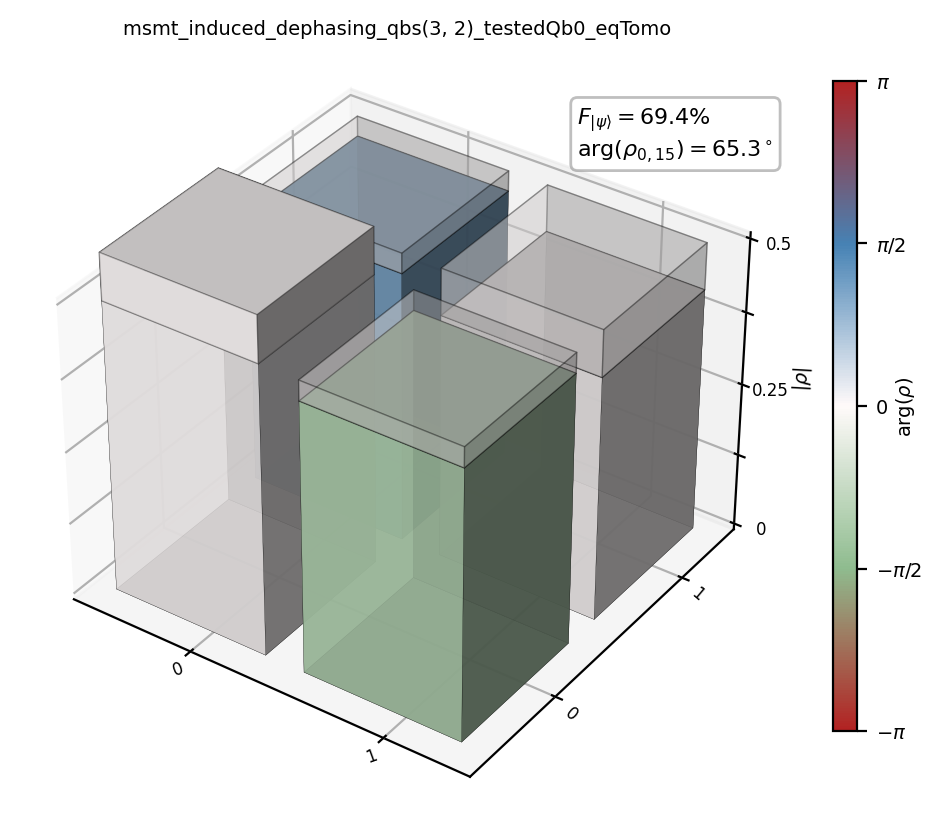

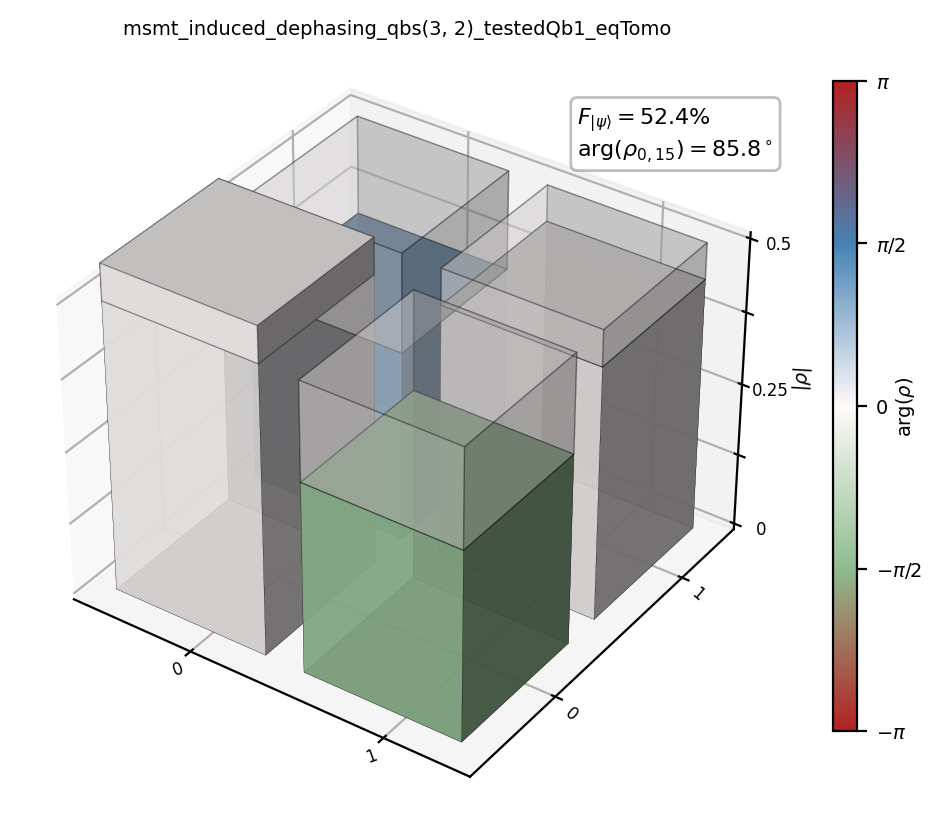

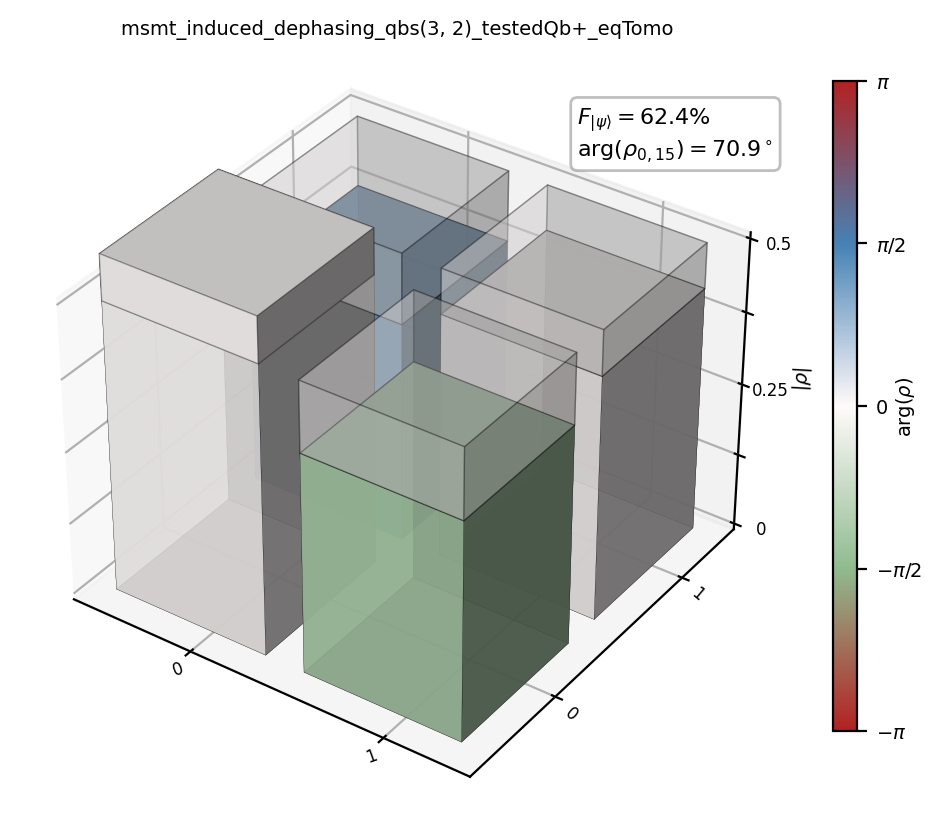

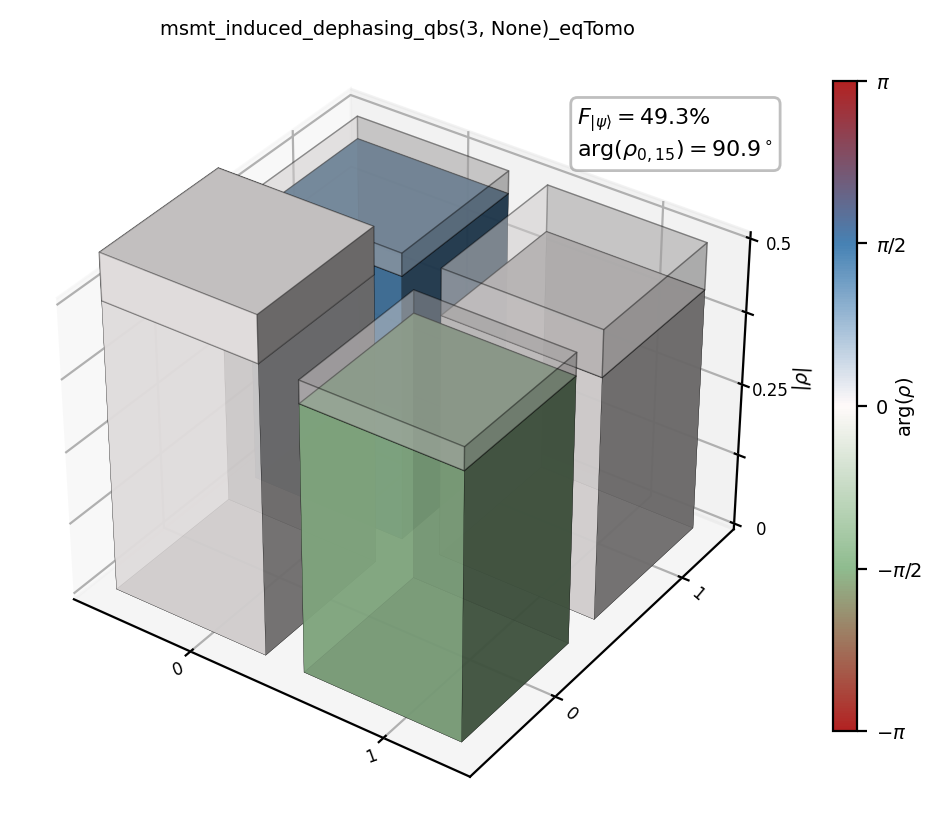

In [23]:
# pairs = [(2,1), (2,3), (2, None)]
pairs = [(3,2), (3, None)]
states = ['0', '1', '+']

for pair in pairs:
    for state in states:
        exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
        exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
        exp_name += "_eqTomo"
        expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb3)
        # R_0 = np.zeros(rho.shape)
        # R_0[-1,-1] = 1.0

        rho0 = np.full(rho.shape, 0.5)
        fid_0 = fidelity(rho, rho0)
        angle_01 = np.angle(rho[0,1], deg=True) #*180/np.pi
        fig = plot_density_matrix(rho, rho_id=rho0, angle=angle_01, fidelity=fid_0,
                                  title=exp_name)
        ExperimentData.save_fig(fig, exp_name)

        if pair[1] is None:
            break

### using pycqed method for tomography analysis

In [22]:
gen_gate_order(1)

array(['Z', 'X', 'Y'], dtype='<U1')

In [ ]:
# pairs = [(2,1), (2,3), (2, None)]
pairs = [(3,2), (3, None)]
states = ['0', '1', '+']

for pair in pairs:
    for state in states:
        exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
        exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
        exp_name += "_eqTomo"
        expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb3)
        # R_0 = np.zeros(rho.shape)
        # R_0[-1,-1] = 1.0

        rho0 = np.full(rho.shape, 0.5)
        fid_0 = fidelity(rho, rho0)
        angle_01 = np.angle(rho[0,1], deg=True) #*180/np.pi
        fig = plot_density_matrix(rho, rho_id=rho0, angle=angle_01, fidelity=fid_0,
                                  title=exp_name)
        ExperimentData.save_fig(fig, exp_name)

In [27]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(1)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)
pair = (3, None)
tomo_qubits = [3]

tomo_shots_dict = {qb: {} for qb in tomo_qubits}
sim_msmt = True


for i, tomo_state in enumerate(gate_order):
    print(tomo_state)
    exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
    exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
    exp_name += f"_eqTomo_M{tomo_state}"
    bitstrings = ExperimentData.get_csv_data(exp_name + "_RAW.csv")
    # print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    # masks_0[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 0, 1, np.nan)
    # masks_1[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in tomo_qubits: # shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

Z
X
Y


{3: {'Z': array([1, 1, 0, ..., 0, 0, 0]),
  'X': array([1, 0, 0, ..., 0, 0, 1]),
  'Y': array([1, 1, 1, ..., 1, 1, 0])}}

In [29]:
Pauli_terms_0, rho_0, P_frac_0 = get_Pauli_expectation_values(beta, gate_order, np.ones(len(tomo_shots_dict[3]['Z'])),
                                                              Tomo_shots_dig=tomo_shots_dict)
# Pauli_terms_1, rho_1, P_frac_1 = get_Pauli_expectation_values(beta, gate_order, masks_1,
#                                                               Tomo_shots_dig=tomo_shots_dict)

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, title=exp_name, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)
